## Main notebook for the icpe data challenge

#### Import libraries

In [435]:
import bson
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib.lines as mlines
from matplotlib.ticker import ScalarFormatter
import matplotlib.patheffects as pe
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import numpy as np

### Import data

In [2]:
data_folder = '../mongodb_performance_results/all/'

files = os.listdir(data_folder)


### we use bsondump to change the bson file to the json format
### see https://docs.mongodb.com/database-tools/bsondump/

### Short description of the files :

### 'em_change_points.json',

# originally in 'expanded_metrics/change_points.bson'
# change_points: Computed change points with annotations.

### 'em_time_series.json'

# originally in 'expanded_metrics/time_series.bson'
# time_series: Performance test results, stored in an array. One document per test measurement.
# The data gathered over time for this time series, 
# with time series being uniquely identified by the combination of 
# project/variant/task/test/measurement/args options. 
# Changing any of those when reporting data causes 
# the data to inserted into another time series.

### 'em_versions.json'

# originally in 'expanded_metrics/versions.bson'
# versions: Information on git versions. 
# denormalized metadata about versions

### 'perf_change_points.json'

# originally in 'perf/change_points.bson'
# change_points: Computed change points

### 'perf_points.json'

# originally in 'perf/points.bson'
# points: The performance results. One document per test result.  

### 'perf_processed_change_points.json'

# originally in 'perf/processed_change_points.bson'
# processed_change_points: Computed change points with human annotations
# This document is the same as in change points, 
# except for the addition of the "processed" field. 
# Objects in the change_points collection were copied 
# to the processed_change_points collection when a person processed the point. 

### 'suspect_points.json'

# originally in the root directory
# 
#data = dict()
#for f_name in files[1:]:
#    print(f_name)
#    with open(data_folder+f_name,'rb') as f:
#        for line in f:
#            test.append(json.loads(line))

#### Import time series

In [67]:
time_series = dict()
ts_args = dict()

with open(data_folder+'em_time_series.json','r') as json_file:
    for line in json_file.readlines():
        jline = json.loads(line)
        key = (jline["measurement"], jline["project"], jline["task"], jline["test"], jline["variant"], jline["_id"]['$oid'])
        time_series[key] = [(dataline["commit_date"]['$date'],int(dataline["value"])) 
                                 for dataline in jline['data'] if dataline["commit_date"] is not None]
        ts_args[key] = jline["args"]

ts_keys = pd.Series([k[0:5] for k in time_series.keys()]).unique()

len(open('../mongodb_performance_results/all/em_time_series.json','r').readlines())

795171

#### Import change points

In [68]:
change_points = dict()

with open(data_folder+'em_change_points.json','r') as json_file:
    for line in json_file.readlines():
        jline = json.loads(line)
        jline_cp = jline["time_series_info"]
        key = (jline_cp["measurement"], jline_cp["project"], jline_cp["task"], 
               jline_cp["test"], jline_cp["variant"])
        if key not in change_points:
            change_points[key] = []
        if "commit_date" in jline and "percent_change" in jline and "z_score_change" in jline:
            change_points[key].append((jline["commit_date"]['$date'], 
                                      jline["percent_change"], 
                                      jline["z_score_change"]))
        
cp_keys = [k for k in change_points.keys()]

len(open(data_folder+'em_change_points.json','r').readlines())

287663

#### Some statistics

In [69]:
measurement = pd.Series([key[0] for key in ts_keys]).unique()
project = pd.Series([key[1] for key in ts_keys]).unique()
task = pd.Series([key[2] for key in ts_keys]).unique()
test = pd.Series([key[3] for key in ts_keys]).unique()
variant = pd.Series([key[4] for key in ts_keys]).unique()

print("measurements", len(measurement))
print("projects", len(project))
print("task",len(task))
print("test",len(test))
print("variants",len(variant))

measurements 156
projects 12
task 130
test 1946
variants 42


('ops_per_sec', 'perf', 'pipeline-updates', 'PipelineUpdate.FindAndModify.GradeAdjustmentSorted', 'linux-wt-repl')


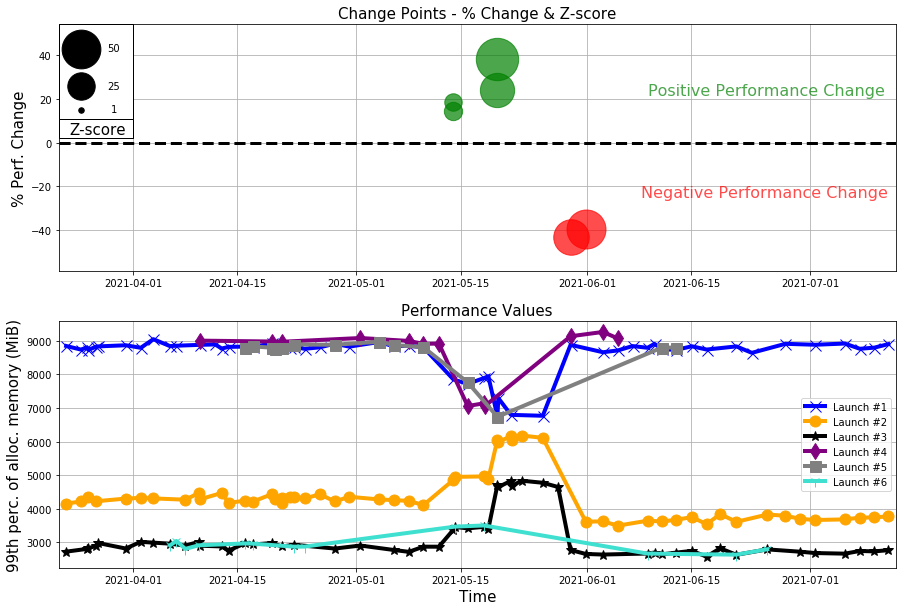

In [543]:
tab = [len(change_points[key]) for key in cp_keys if len(change_points[key])>0]

not_found = True

while not_found:
    i = np.random.randint(0, len(tab))
    if tab[i] > 5:
        #if [key for key in cp_keys if len(change_points[key])>0][i][0] != 'ops_per_sec':
        my_special_key = [key for key in cp_keys if len(change_points[key])>0][i]
        print(my_special_key)
        not_found = False

my_special_key = ('ss tcmalloc generic current_allocated_bytes (MiB) - p99', 'sys-perf', 'industry_benchmarks_wmajority', 'ycsb_50read50update_w_majority', 'linux-3-node-replSet')


list_all_ts = [key for key in time_series.keys() if key[0:5] == my_special_key]

fig, axs = plt.subplots(2, 1, figsize=((15, 10)))   

min_all_dates = min(([min([k[0] for k in time_series[key]]) for key in list_all_ts]))
max_all_dates = max(([max([k[0] for k in time_series[key]]) for key in list_all_ts]))

# up 

cps = change_points[my_special_key]
dates = [datetime.strptime(cp[0], '%Y-%m-%dT%H:%M:%S.000Z') for cp in cps]
percent_changes = [cp[1] for cp in cps]
z_scores = [np.abs(cp[2]) for cp in cps]

axs[0].grid(zorder = 0)

std_factor = 2

axs[0].set_xlim(datetime.strptime(min_all_dates, '%Y-%m-%dT%H:%M:%S.000Z')+relativedelta(days=-1), 
                datetime.strptime(max_all_dates, '%Y-%m-%dT%H:%M:%S.000Z')+relativedelta(days=1))
axs[0].set_ylim(min(percent_changes)-np.std(percent_changes)/std_factor,
                max(percent_changes)+np.std(percent_changes)/std_factor)


for i in range(len(dates)):
    if percent_changes[i] > 0:
        axs[0].scatter(dates[i], percent_changes[i], s = int(50*z_scores[i]), 
                       color = "green", alpha =0.7, zorder = 4)
    else:
        axs[0].scatter(dates[i], percent_changes[i], s = int(50*z_scores[i]), 
                       color = "red", alpha =0.7, zorder = 4)
axs[0].get_yaxis().set_major_formatter(ScalarFormatter())
axs[0].set_ylabel("% Perf. Change", size = 15)
axs[0].set_xlabel("", size = 15)
axs[0].set_title("Change Points - % Change & Z-score", size = 15)

axs[0].hlines(0, axs[0].get_xlim()[0], axs[0].get_xlim()[1], linestyles='dashed', linewidth = 3, color='black')

min_date = datetime.strptime(min_all_dates, '%Y-%m-%dT%H:%M:%S.000Z')+relativedelta(days=-1)

axs[0].add_patch(pat.Rectangle(
        (min_date, 2),
        relativedelta(days=10),
        axs[0].get_ylim()[1]-2,
        edgecolor = 'black',
        facecolor = 'white',
        fill=True,
        zorder=3
 ))

axs[0].add_patch(pat.Rectangle(
        (min_date, 2),
        relativedelta(days=10),
        9,
        edgecolor = 'black',
        facecolor = 'white',
        fill=True,
        zorder=3
 ))

axs[0].scatter(min_date+relativedelta(days=3), 15, s = 30, color = "black", zorder =4)
axs[0].text(min_date+relativedelta(days=7), 14,"1")
axs[0].scatter(min_date+relativedelta(days=3), 26, s =30*25, color = "black", zorder =4)
axs[0].text(min_date+relativedelta(days=6.5), 24.5,"25")
axs[0].scatter(min_date+relativedelta(days=3), 43, s =30*50, color = "black", zorder =4)
axs[0].text(min_date+relativedelta(days=6.5), 42,"50")
axs[0].text(min_date+relativedelta(days=1.5), 4,"Z-score", size= 15)

axs[0].text(datetime(2021, 6, 9, 2, 55, 29), 22,"Positive Performance Change", 
            color = "green", size = 16, alpha =0.7, zorder =4)
axs[0].text(datetime(2021, 6, 8, 4, 55, 29), -25,"Negative Performance Change", 
            color = "red", size = 16, alpha =0.7, zorder =4)

# down
axs[1].grid(zorder = 0)

min_all_perf = min(([min([k[1] for k in time_series[key]]) for key in list_all_ts]))
max_all_perf = max(([max([k[1] for k in time_series[key]]) for key in list_all_ts]))

colors = ['blue', 'orange', 'black', 'purple', 'grey', 'turquoise', 'green', 'red']
markers = ["x", "o", "*", "d", "s", "1", "2"]

axs[1].set_xlim(datetime.strptime(min_all_dates, '%Y-%m-%dT%H:%M:%S.000Z')+relativedelta(days=-1), 
                datetime.strptime(max_all_dates, '%Y-%m-%dT%H:%M:%S.000Z')+relativedelta(days=1))


for j in range(len(list_all_ts)):
    
    key = list_all_ts[j]
    jmod7 = j%7

    df = pd.DataFrame(time_series[key], columns = ["date", "perf"])
    df.sort_values(by='date')

    dates = [datetime.strptime(strd, '%Y-%m-%dT%H:%M:%S.000Z') for strd in df['date']]
    
    axs[1].plot(dates, df.perf, color = colors[jmod7], marker= markers[jmod7], markersize=11, 
                linewidth = 4, label = 'Launch #'+str(j+1), zorder = 4)

axs[1].legend()

#handles, labels = ax.get_legend_handles_labels()
#p = []
#ax.plot(df.date, df.est, color = colors[i], linewidth = 5, label = sys)
#p.append(mlines.Line2D([], [], color=colors[i], 
#marker= markers[i], markersize=10, linewidth = 5, label=sys_name))
#ax.text(dates[i], vals[i], sys_name, color = colors[i], size = 20, 
#            path_effects=[pe.withStroke(linewidth=6, foreground="white")])
#ax.legend(handles=p)
#ax.set_yscale('log')
#ax.set_yticks([3, 5, 10, 20, 30, 50,100, 150])
#plt.savefig("./results/evolution_perf.png", dpi = 300)

axs[1].get_yaxis().set_major_formatter(ScalarFormatter())
#axs[1].set_ylabel(my_special_key[0], size = 15)
axs[1].set_ylabel("99th perc. of alloc. memory (MiB)", size = 15)
axs[1].set_xlabel("Time", size = 15)
axs[1].set_title("Performance Values", size = 15)
plt.savefig('./results/fig1.png', dpi = 300)
plt.show()

In [362]:
# same
# ('Data - disk xvde disk written (writes/s) - p99', 'sys-perf', 'initialsync-large', 'initialsync_large_c_32_d_32_w_t', 'linux-3-node-replSet-initialsync')
# ('Latency95thPercentile', 'sys-perf', 'linkbench2', 'ADD_LINK_ms', 'linux-3-node-replSet')
# ('Latency99thPercentile', 'sys-perf', 'linkbench2', 'DELETE_LINK_ms', 'linux-3-node-replSet')
# ('Data - disk xvde utilization (%) - p99', 'sys-perf-4.4', 'mongos_workloads', 'benchRun', 'linux-3-shard')
# ('ss wt block-manager bytes written (MiB/s) - max', 'sys-perf', 'snapshot_reads', 'benchRun', 'linux-3-node-replSet')
# ('Data - disk xvde disk written (writes/s) - p99', 'sys-perf', 'mixed_writes_replica', 'mixed_writes_replica', 'linux-1-node-15gbwtcache')
# ('Data - disk xvde disk written (writes/s) - p99', 'sys-perf', 'industry_benchmarks_wmajority', 'ycsb_50read50update_w_majority', 'linux-shard-lite')
# ('ops_per_sec', 'performance', 'misc_custom_filter_default', 'Remove.IntNonIdNoIndex', 'linux-wt-standalone')

# different
# ('Journal - disk xvdf disk written (writes/s) - p99', 'sys-perf', 'industry_benchmarks_wmajority', 'ycsb_95read5update_w_majority', 'linux-shard-lite')
# ('Journal - disk xvdf disk written (writes/s) - mean', 'sys-perf', 'bestbuy_agg_merge_different_db', 'benchRun', 'linux-shard-lite')
# ('ss tcmalloc generic current_allocated_bytes (MiB) - max', 'sys-perf', 'industry_benchmarks_secondary_reads', 'ycsb_95read5update_secondary_reads', 'linux-3-node-replSet')
# ('Data - disk xvde utilization (%) - mean', 'sys-perf', 'industry_benchmarks', 'ycsb_50read50update', 'linux-3-node-replSet')
# ('Journal - disk xvdf disk written (writes/s) - mean', 'sys-perf', 'change_streams_latency', 'change_streams_latency_update_lookup', 'linux-3-node-replSet')
# ('Data - disk xvde utilization (%) - p99', 'sys-perf', 'bestbuy_agg_merge_target_hashed', 'benchRun', 'linux-shard-lite')
#('Journal - disk xvdf utilization (%) - mean', 'sys-perf', 'snapshot_reads', 'benchRun', 'linux-3-node-replSet')
#('ss tcmalloc generic current_allocated_bytes (MiB) - p99', 'sys-perf', 'industry_benchmarks_wmajority', 'ycsb_50read50update_w_majority', 'linux-3-node-replSet')
#('ss tcmalloc generic current_allocated_bytes (MiB) - max', 'sys-perf', 'industry_benchmarks_wmajority', 'ycsb_95read5update_w_majority', 'linux-shard-lite')
